<a href="https://colab.research.google.com/github/Hyeji-Jo/Study/blob/main/Wav_to_STFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 환경 준비

In [2]:
!pip install librosa matplotlib numpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# 1. WAV 파일

- 이산화된 시간 영역의 디지털 신호
- $x[n], \quad n = 0,1,2,\dots, N-1$
  - N : 전체 샘플 개수

In [14]:
# 예제 WAV 파일 (librosa에서 제공하는 샘플 사용)
audio_path = librosa.example('trumpet')  # trumpet.wav 샘플
x, sr = librosa.load(audio_path, sr=None)

In [15]:
print(f"Sample Rate (f_s): {sr}")
print(f"Number of samples (N): {len(x)}")
print("First 10 samples x[n]:", x[:10])

Sample Rate (f_s): 22050
Number of samples (N): 117601
First 10 samples x[n]: [-1.4068222e-03 -4.4607258e-04 -4.1098078e-04  9.9921570e-05
  4.3149794e-05 -1.7485465e-04 -3.6783575e-04  1.4553106e-04
  5.0557934e-04  1.4929953e-03]


# 2. STFT

1. Framing
  - 전체 신호를 일정 길이로 자르기
2. Windowing
  - 프레임의 중앙부는 그대로 유지하고, 양 끝은 서서히 0으로 만들어 경계 완화
3. FFT
  - 자른 프레임 각각에 대해 주파수 분석

## 1) Framing

- 전체 신호 x[n]를 frame 단위로 자르기
- Frame m : $x_m[n] = x[n + mR],   0 ≤ n < L$
  - m : frame index
  - L: frame 길이
  - R: hop size (frame 간격)

In [17]:
frame_length = 1024
hop_length = 512

# 첫 번째 프레임 추출
frame_0 = x[0 : frame_length]
print("First frame x_0[n]:", frame_0[:10])

First frame x_0[n]: [-1.4068222e-03 -4.4607258e-04 -4.1098078e-04  9.9921570e-05
  4.3149794e-05 -1.7485465e-04 -3.6783575e-04  1.4553106e-04
  5.0557934e-04  1.4929953e-03]


frame 0 : $x_0[n] = x[n]$

In [18]:
# 두 번째 프레임 추출
frame_1 = x[hop_length : hop_length + frame_length]
print("Second frame x_1[n]:", frame_1[:10])

Second frame x_1[n]: [ 0.1331392   0.14719851  0.10942959  0.00823579 -0.12659869 -0.25486928
 -0.33510053 -0.34459624 -0.29521525 -0.21606602]


frame 1 : $x_1[n] = x[n + R]$

In [19]:
# 세 번째 프레임 추출
frame_2 = x[2 * hop_length : 2 * hop_length + frame_length]
print("Third frame x_2[n]:", frame_2[:10])

Third frame x_2[n]: [ 0.11304095  0.11642584  0.10367279  0.07544775  0.0445258   0.02528933
  0.01535569  0.0040498  -0.00276635 -0.00840293]


frame 2 : $x_2[n] = x[n + 2*R]$

## 2) Windowing

- $s_m[n] = x[n + mR] * w[n]$

- 프레이밍을 하면 구간과 구간 사이의 경계에서 불연속성 발생
  - 잘린 프레임의 시작&끝이 급격히 0으로 끊기면 FFT에서는 **고주파 성분**이 잘못 생긴것 처럼 나타남
  - 신호가 주기적으로 반복된다고 가정하기 때문에
  - 시작값이 0.1이고 끝값이 -0.4면 -0.4에서 0.1로 갑자기 점프하는 신호로 인식하기에 -> 양끝을 0에 가깝게 풀어줌
  - 변화가 급격하면 -> 고주파 / 완만하면 -> 저주파
- 그래서 경계 부분을 부드럽게 줄이는 window function을 곱해서 불연속성 억제

- Hann window 예: $w[n] = 0.5 \left( 1 - \cos\left( \frac{2\pi n}{L-1} \right) \right), \quad 0 \leq n < L$
  - 프레임의 양 끝에서 부드럽게 0으로 수렴하면서, 중앙에서는 1에 가까운 값을 갖는 tapering 함수
  - cosine 함수의 경우 $\cos(0) = 1$, $\cos(\pi) = -1$
  - 그러므로 0에서 π까지 “부드럽게 감소”
  - hann window 수식에서 n=0일때, $w[0] = 0.5 (1 - \cos(0)) = 0.5 (1 - 1) = 0$
  - 다른 끝부분인 L-1일때, $w[L-1] = 0.5 (1 - \cos(2\pi (L-1)/(L-1))) = 0.5(1 - \cos(2\pi)) = 0$

  
  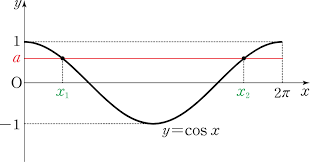  
      

In [20]:
# hann window 내장 함수 사용
w_lib = np.hanning(frame_length)
print(w_lib)

[0.00000000e+00 9.43076912e-06 3.77227207e-05 ... 3.77227207e-05
 9.43076912e-06 0.00000000e+00]


In [21]:
n = np.arange(frame_length)
print(n)

[   0    1    2 ... 1021 1022 1023]


In [22]:
# 직접 수식으로 계산
w_manual = 0.5 * (1 - np.cos(2 * np.pi * n / (frame_length - 1)))
print(w_manual)

[0.00000000e+00 9.43076912e-06 3.77227207e-05 ... 3.77227207e-05
 9.43076912e-06 0.00000000e+00]


In [23]:
# window를 적용하지 않았을때
N = 1024
X_rect = np.abs(np.fft.fft(frame_0, n=N))

In [24]:
# hann 윈도우를 적용했을 때
w = np.hanning(frame_length)
windowed_frame_0 = frame_0 * w
X_hann = np.abs(np.fft.fft(windowed_frame_0, n=N))

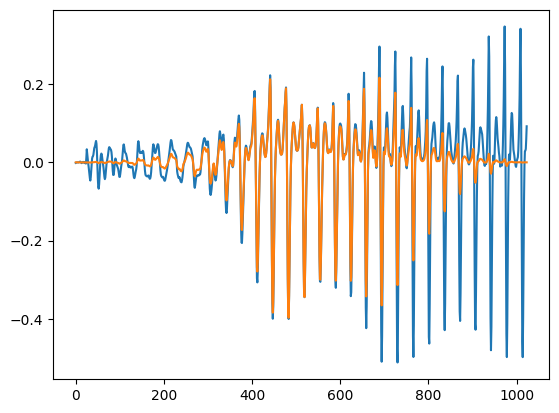

In [25]:
# Plot 비교
plt.plot(frame_0, label='No window (Rectangular)')
plt.plot(windowed_frame_0, label='Hann window')

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


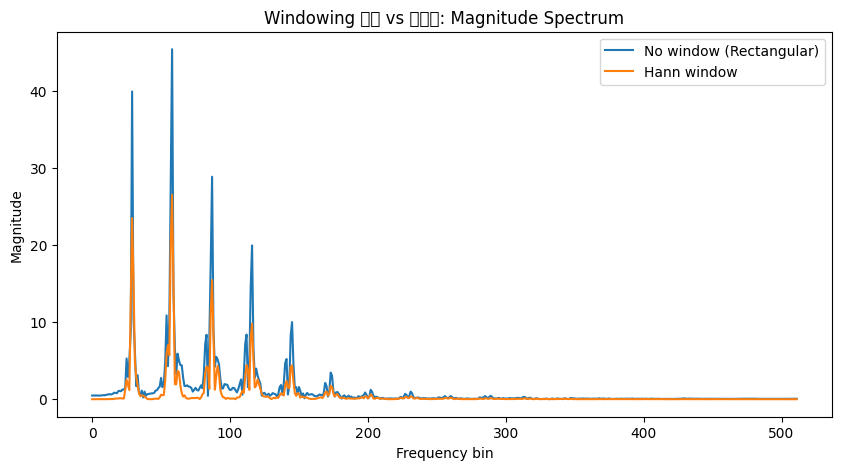

In [26]:
# FFT 적용한 Plot 비교
plt.figure(figsize=(10,5))
plt.plot(X_rect[:N//2], label='No window (Rectangular)')
plt.plot(X_hann[:N//2], label='Hann window')
plt.legend()
plt.title('Windowing 적용 vs 미적용: Magnitude Spectrum')
plt.xlabel('Frequency bin')
plt.ylabel('Magnitude')
plt.show()

## 3) FFT (주파수 변환)

- Frame $s_m[n]$ 에 대해 : $X_m[k] = \sum_{n=0}^{L-1} s_m[n] \cdot e^{-j 2\pi k n / N}$
  - N=1024 기준으로 주파수 bin 0~1023 생성
  - k = 몇 번 진동하느냐
  - x[n]이라는 신호에 k번째 주파수가 얼마나 들어있나를 알고 싶으면, **k번째 주파수 모양에 “겹쳐서 비교”**
    - 겹친다 = inner product(내적) = 곱하고 더한다
- 주어진 이산 신호에서 주파수 성분의 “크기”와 “위치”를 분석하기 위해
- 신호에 특정 주파수가 얼마나 들어 있는지 측정하기 위해  
  


---


- 모든 신호는 sin과 cos으로 이뤄져 있으며, 코사인파 + 사인파 = 진동 모양을 표현할 수 있는 가장 기본적인 방법
  - $\exp(-j 2\pi k n / N) = \cos(2\pi k n / N) - j \sin(2\pi k n / N)$

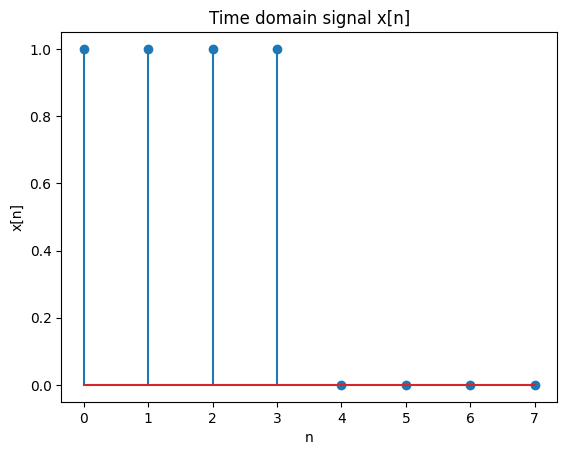

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 간단한 예제 신호
N = 8  # 작은 N으로 해봐야 일일이 확인하기 쉬움
n = np.arange(N)
x = np.array([1, 1, 1, 1, 0, 0, 0, 0])  # 아주 단순한 rectangular pulse

plt.stem(n, x)
plt.title("Time domain signal x[n]")
plt.xlabel("n")
plt.ylabel("x[n]")
plt.show()

### 왜 basis인가?
- 2D 공간에서 어떤 벡터는 x, y축으로 분해할 수 있듯이,
- 신호도 여러 개의 “주파수 방향 축”으로 분해할 수 있음
- 여기서 주파수 방향도 서로 직교하고 완전한 basis가 된다

In [6]:
import numpy as np

N = 8
n = np.arange(N)

# Pure cosine wave at frequency k=2
x = np.cos(2 * np.pi * 2 * n / N)

# Manual projection onto frequency k=2 basis
k = 2
basis = np.exp(-1j * 2 * np.pi * k * n / N)
projection = np.sum(x * basis)
print(f"Projection onto k=2: {projection} (should be large) -> k=2 주파수 성분이 존재함을 의미")

# Projection onto wrong frequency k=3
k_wrong = 3
basis_wrong = np.exp(-1j * 2 * np.pi * k_wrong * n / N)
projection_wrong = np.sum(x * basis_wrong)
print(f"Projection onto k=3: {projection_wrong} (should be near zero)")

Projection onto k=2: (4-2.449293598294706e-16j) (should be large) -> k=2 주파수 성분이 존재함을 의미
Projection onto k=3: (-2.1011617250009018e-17-3.6739403974420574e-16j) (should be near zero)


In [7]:
# 복소지수 term 직접 계산
k = 1  # 예를 들어 1번째 bin
basis = np.exp(-1j * 2 * np.pi * k * n / N)
print("Basis function (k=1):", basis)

Basis function (k=1): [ 1.00000000e+00+0.00000000e+00j  7.07106781e-01-7.07106781e-01j
  6.12323400e-17-1.00000000e+00j -7.07106781e-01-7.07106781e-01j
 -1.00000000e+00-1.22464680e-16j -7.07106781e-01+7.07106781e-01j
 -1.83697020e-16+1.00000000e+00j  7.07106781e-01+7.07106781e-01j]


In [8]:
# 각 샘플별 곱하기
products = x * basis
print("x[n] * exp(-j 2π k n / N):", products)

x[n] * exp(-j 2π k n / N): [ 1.00000000e+00+0.00000000e+00j  4.32978028e-17-4.32978028e-17j
 -6.12323400e-17+1.00000000e+00j  1.29893408e-16+1.29893408e-16j
 -1.00000000e+00-1.22464680e-16j -2.16489014e-16+2.16489014e-16j
  1.83697020e-16-1.00000000e+00j -3.03084620e-16-3.03084620e-16j]


In [9]:
# sum 연산으로 projection
Xk = np.sum(products)
print(f"X[1] (manual calc): {Xk}")

X[1] (manual calc): (-2.23917742579462e-16-1.224646799147354e-16j)


In [10]:
# 내장 함수 결과와 비교
X = np.fft.fft(x, n=N)
print(f"X[1] (np.fft.fft result): {X[1]}")

X[1] (np.fft.fft result): (-3.4638242249419736e-16+0j)


In [28]:
N = 1024
X_0 = np.fft.fft(windowed_frame_0, n=N)

print("First 10 FFT magnitudes |X_0[k]|:", np.abs(X_0[:10]))

First 10 FFT magnitudes |X_0[k]|: [0.00216209 0.00224928 0.00345949 0.00520618 0.00765337 0.01291784
 0.01043309 0.0065451  0.01155933 0.01529782]


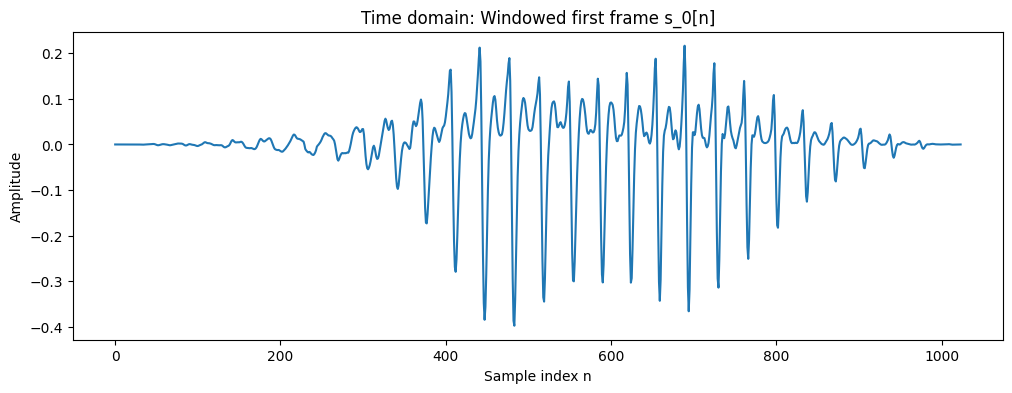

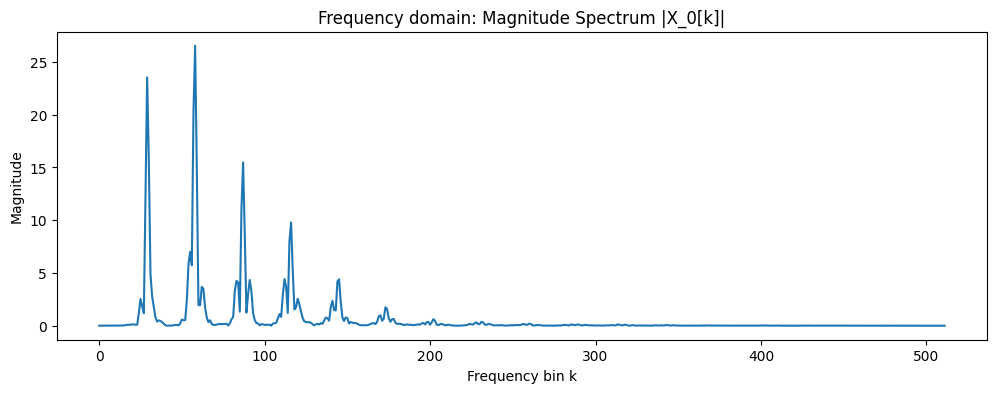

In [29]:
# Plot: Time domain
plt.figure(figsize=(12,4))
plt.plot(windowed_frame_0)
plt.title("Time domain: Windowed first frame s_0[n]")
plt.xlabel("Sample index n")
plt.ylabel("Amplitude")
plt.show()

# Plot: Frequency domain
plt.figure(figsize=(12,4))
plt.plot(np.abs(X_0[:N//2]))
plt.title("Frequency domain: Magnitude Spectrum |X_0[k]|")
plt.xlabel("Frequency bin k")
plt.ylabel("Magnitude")
plt.show()

## Shape 알아보기

In [4]:
# 예제 WAV 파일 (librosa에서 제공하는 샘플 사용)
audio_path = librosa.example('trumpet')  # trumpet.wav 샘플
x, sr = librosa.load(audio_path, sr=None)

In [5]:
# FFT의 shape = (len(audio), )
X = np.fft.fft(x)
print(f"FFT result shape: {X.shape}")

FFT result shape: (117601,)


- frame 수  
$frames = 1 + \frac{L-n fft}{hop length}$

In [6]:
X

array([ 0.00431729-1.9761970e-14j, -0.00627852+2.0084698e-03j,
        0.0109353 +1.0481768e-02j, ...,  0.00929817+9.7385775e-03j,
        0.0109353 -1.0481768e-02j, -0.00627852-2.0084698e-03j],
      dtype=complex64)

In [7]:
# STFT의 shape → shape = (freq_bins=513, frames=frame_count)
n_fft = 1024
hop_length = 256

S_F = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, center=False)
print(f"STFT result shape: {S_F.shape}")

STFT result shape: (513, 456)


In [8]:
# center=True 기본 옵션
# → shape = (freq_bins=513, frames=frame_count+padding)
S_T = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, center=True)
print(f"STFT result shape: {S_T.shape}")

STFT result shape: (513, 460)


In [9]:
S_T

array([[ 5.8212312e-04+0.0000000e+00j,  1.3029488e-04+0.0000000e+00j,
         2.1510886e-03+0.0000000e+00j, ...,
        -2.3162057e-09+0.0000000e+00j, -4.3203829e-07+0.0000000e+00j,
        -1.6365074e-06+0.0000000e+00j],
       [-2.4783255e-03-3.1073401e-03j,  2.3725345e-03+2.0899198e-03j,
        -2.2384499e-03-2.9990743e-04j, ...,
        -2.8528016e-09-2.1121571e-09j, -2.0788191e-07-3.6289762e-07j,
         1.3995545e-06-8.5098435e-07j],
       [ 4.6571968e-03+4.4815047e-03j, -3.7461268e-03-5.8173430e-03j,
         1.5679308e-03+3.0804253e-03j, ...,
        -1.2883558e-09-1.9177344e-09j,  1.8426317e-07-3.4859281e-07j,
        -6.9828042e-07+1.4362115e-06j],
       ...,
       [-7.4032089e-04+1.2097482e-05j,  3.7228662e-04-2.6631137e-06j,
        -7.9653892e-06-1.2318574e-06j, ...,
        -6.0197810e-04+6.0259743e-04j,  5.3512730e-04-5.6154811e-05j,
        -1.2410860e-04-1.4805383e-04j],
       [ 7.4187131e-04-8.2144134e-06j, -6.4561837e-06-3.6647634e-04j,
         3.6788490e-06

- 실제 Hz로 변환하는 수식  
  $ f_k = \frac{k}{N} \cdot f_s $
  - k: 주파수 bin index (0~512)
  - N: n_fft
  - f_s: 샘플링 레이트

- HZ : 초당 몇번 진동하는지
- 샘플링 rate fs : 1초에 fs 샘플
- 그럼 전체 N개의 샘플은 몇초가 소요?
  - $\text{duration} = \frac{N}{f_s} \text{초}$
- K 번째 bin -> N 샘플 구간에서 K번 진동하는 주파수
  - 즉, duration 동안 K번 진동하는데
  - 초당 몇번 진동하는지 초 단위로 바꾸면
  - $f_k = \frac{k}{\text{duration (초)}} = \frac{k}{N/f_s} = \frac{k}{N} \cdot f_s$
- **"전체 N개 샘플에서 k번 진동했다 → 초당 몇 번 진동인가로 변환 → Hz"**

In [10]:
import numpy as np

n_fft = 1024
sr = 22050

freqs = np.linspace(0, sr / 2, n_fft // 2 + 1)  # 513개의 주파수 값 (0Hz~Nyquist까지)

In [11]:
print(f"주파수 shape: {freqs.shape}")
print(f"주파수 값 예시: {freqs[:5]}")

주파수 shape: (513,)
주파수 값 예시: [ 0.         21.53320312 43.06640625 64.59960938 86.1328125 ]


In [12]:
freqs[500:]

array([10766.6015625 , 10788.13476562, 10809.66796875, 10831.20117188,
       10852.734375  , 10874.26757812, 10895.80078125, 10917.33398438,
       10938.8671875 , 10960.40039062, 10981.93359375, 11003.46679688,
       11025.        ])

In [38]:
# Mel-spectrogram의 shape
# → shape = (mel_bands=128, frames=frame_count)
n_mels = 128
mel_spec = librosa.feature.melspectrogram(S=np.abs(S_T), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
print(f"Mel-spectrogram shape: {mel_spec.shape}")

Mel-spectrogram shape: (128, 460)


In [48]:
mel_spec

array([[2.11417762e-04, 1.90947845e-04, 1.17364645e-04, ...,
        1.44474196e-10, 1.85858973e-08, 7.34665946e-08],
       [3.40139784e-04, 2.24534248e-04, 1.89448969e-04, ...,
        1.18471191e-10, 1.77722974e-08, 7.19590290e-08],
       [5.71537355e-04, 3.73659510e-04, 2.97669438e-04, ...,
        1.21066088e-10, 1.82980475e-08, 7.20045534e-08],
       ...,
       [5.19347144e-04, 3.54708900e-04, 1.65301200e-04, ...,
        4.93121343e-06, 3.21369998e-06, 1.95494499e-06],
       [3.13376833e-04, 2.03452582e-04, 1.59934614e-04, ...,
        1.31970137e-05, 1.20054829e-05, 8.39690165e-06],
       [5.39422617e-05, 3.65465530e-05, 2.87645908e-05, ...,
        1.07703618e-05, 1.51316908e-05, 1.39170952e-05]], dtype=float32)

# 3. Energy

- $\text{Energy}(t) = \sqrt{ \sum_{m=1}^M S(t, m)^2 }$
  - mel-spectrogram의 각 frame에 대해 전체 mel-bin의 amplitude(L2 norm)
- 발화의 볼륨과 강세에 대한 정보를 나타내는 특징

- 딱히 TacotronSTFT라는 내장함수가 존재하는게 아니라  
  STFT 결과에 mel filterbank 적용 + Tacotron2 Style compression의 작업을 표준화한 것
- Tacotron2에서 정의된 setup 그대로 사용하는 것을 강조하기 위한 이름

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# TacotronSTFT-style 파라미터
n_fft = 1024
hop_length = 256
win_length = 1024 #-> 보통 n_fft=win_length 동일하게 설정
n_mel_channels = 80 #-> mel-spectrogram의 mel band 개수/일반적으로 80 사용
                    #   몇 개 구간으로 나눠서 계산할 지
                    #    -> 즉, 0~8000HZ를 80개 나눠서 각 구간에 energy 도출
mel_fmin = 0 #-> mel filterbank의 최소 주파수 보통 0 사용
mel_fmax = 8000  #-> mel filterbank의 최대 주파수
                 #   인간의 음성 주요 정보가 8000HZ 이내에 있음 그 이후는 noise에 가까움

In [ ]:
# 1️⃣ trumpet 데이터 로드
audio_path = librosa.example('trumpet')
y, sr = librosa.load(audio_path, sr=None)

In [ ]:
sr

22050

In [ ]:
len(y)

117601

In [ ]:
## waveform이 [-1, 1] 범위에 있는지 검사 (Tacotron2 입력 규격에 맞는지 확인)
## 조건 만족하면 통과, 아니면 AssertionError 발생
## 대부분 TTS 모델에서는 waveform 입력이 normalize된 상태 기준으로 설계됨
assert np.min(y) >= -1 and np.max(y) <= 1  # waveform range check

In [ ]:
# 2️⃣ STFT → Magnitude
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
## STFT의 결과는 복소수로 주파수별 에너지의 크기를 보기 위해 절댓값 필요
## stft = magnitude+phase(위상)에 절댓값을 취해 magnitude 도출
magnitudes = np.abs(stft) #-> 절댓값

In [ ]:
print(stft[:10])

[[ 5.8212312e-04+0.0000000e+00j  1.3029488e-04+0.0000000e+00j
   2.1510886e-03+0.0000000e+00j ... -2.3162057e-09+0.0000000e+00j
  -4.3203829e-07+0.0000000e+00j -1.6365074e-06+0.0000000e+00j]
 [-2.4783255e-03-3.1073401e-03j  2.3725345e-03+2.0899198e-03j
  -2.2384499e-03-2.9990743e-04j ... -2.8528016e-09-2.1121571e-09j
  -2.0788191e-07-3.6289762e-07j  1.3995545e-06-8.5098435e-07j]
 [ 4.6571968e-03+4.4815047e-03j -3.7461268e-03-5.8173430e-03j
   1.5679308e-03+3.0804253e-03j ... -1.2883558e-09-1.9177344e-09j
   1.8426317e-07-3.4859281e-07j -6.9828042e-07+1.4362115e-06j]
 ...
 [-1.2215233e-02+2.1842806e-02j  1.9240916e-02-1.6393813e-03j
  -4.6259058e-03-4.5951437e-03j ... -1.7186514e-09+3.0710554e-09j
  -2.3320113e-07-2.7587555e-07j -1.0739420e-06+9.9693352e-07j]
 [ 1.0587449e-02-1.8371969e-02j  3.5244639e-03+8.8183035e-04j
  -6.0238582e-03+9.8881070e-03j ... -3.3506544e-09+3.1929432e-09j
   9.4007383e-08-3.3753730e-07j  3.8532718e-07-1.3910044e-06j]
 [-1.4673477e-02+2.9658245e-02j -1.78845

In [ ]:
print(magnitudes[:10])

[[5.8212312e-04 1.3029488e-04 2.1510886e-03 ... 2.3162057e-09
  4.3203829e-07 1.6365074e-06]
 [3.9746272e-03 3.1617535e-03 2.2584514e-03 ... 3.5496035e-09
  4.1822190e-07 1.6379645e-06]
 [6.4632320e-03 6.9191726e-03 3.4565048e-03 ... 2.3103173e-09
  3.9429668e-07 1.5969656e-06]
 ...
 [2.5026388e-02 1.9310629e-02 6.5203030e-03 ... 3.5192531e-09
  3.6123413e-07 1.4653423e-06]
 [2.1204324e-02 3.6331075e-03 1.1578494e-02 ... 4.6283657e-09
  3.5038380e-07 1.4433884e-06]
 [3.3089612e-02 3.0950159e-02 1.5274964e-02 ... 4.6493613e-09
  3.8164563e-07 1.4336554e-06]]


In [ ]:
# 3️⃣ Mel filterbank 생성 (librosa_mel_fn equivalent)
## 주파수 축을 Mel scale로 바꾸는 집합
mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax)

In [ ]:
print(mel_basis)

[[-0.          0.01552772  0.02265139 ...  0.          0.
   0.        ]
 [ 0.          0.          0.00420203 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
# 4️⃣ Mel-spectrogram 계산
# Mel-spectrogram은 사람의 청각에 맞춘 분석인데 사람의 경우 amplitude(에너지)는 잘 구분하지만 phase 정보에는 둔감
# 즉, 청각적으로 거의 영향을 주지 않기에 amplitude 정보만 요약
mel_spectrogram = np.dot(mel_basis, magnitudes**2)

In [ ]:
print(mel_spectrogram)

[[2.72024598e-04 2.22472561e-04 1.50337524e-04 ... 1.29138297e-10
  1.82196871e-08 7.29166274e-08]
 [5.67563809e-04 3.97724187e-04 2.95932055e-04 ... 1.22332602e-10
  1.82985520e-08 7.21244291e-08]
 [1.19562610e-03 1.25550816e-03 5.21398615e-04 ... 1.30668060e-10
  1.94623890e-08 7.30835765e-08]
 ...
 [8.26871372e-04 1.06857577e-03 9.99916345e-04 ... 1.55178441e-05
  1.24651497e-05 1.25743645e-05]
 [7.09069427e-04 7.62384676e-04 1.35254895e-03 ... 1.90046376e-05
  1.43561329e-05 1.18970820e-05]
 [6.40802900e-04 5.26856864e-04 6.17074838e-04 ... 1.37102743e-05
  7.73321244e-06 6.48907462e-06]]


In [ ]:
# 5️⃣ Spectral normalize (log compression)
## 원래 amplitude의 값은 최소~최대 범위가 매우 큼
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

mel_spectrogram_normalized = dynamic_range_compression(mel_spectrogram)

In [ ]:
print(mel_spectrogram_normalized)

[[ -8.209618   -8.4107065  -8.802628  ... -11.512925  -11.512925
  -11.512925 ]
 [ -7.4741573  -7.829752   -8.1253805 ... -11.512925  -11.512925
  -11.512925 ]
 [ -6.7290854  -6.680215   -7.5589957 ... -11.512925  -11.512925
  -11.512925 ]
 ...
 [ -7.0978613  -6.8414288  -6.907839  ... -11.07352   -11.292574
  -11.283851 ]
 [ -7.2515574  -7.1790595  -6.6057644 ... -10.870828  -11.151334
  -11.339217 ]
 [ -7.3527884  -7.5485816  -7.39052   ... -11.197365  -11.512925
  -11.512925 ]]


In [ ]:
# 6️⃣ Energy 계산 (TacotronSTFT-style)
energy = np.linalg.norm(magnitudes, axis=0)  # dim=1 in PyTorch == axis=0 in NumPy

In [ ]:
print(f"Mel-spectrogram shape: {mel_spectrogram.shape}")
print(f"Energy shape: {energy.shape}")
print(f"First 10 energy values: {energy[:10]}")

Mel-spectrogram shape: (80, 460)
Energy shape: (460,)
First 10 energy values: [ 9.586094 32.038292 58.089455 70.14114  74.05198  72.52095  68.298935
 66.637634 65.06732  63.10598 ]


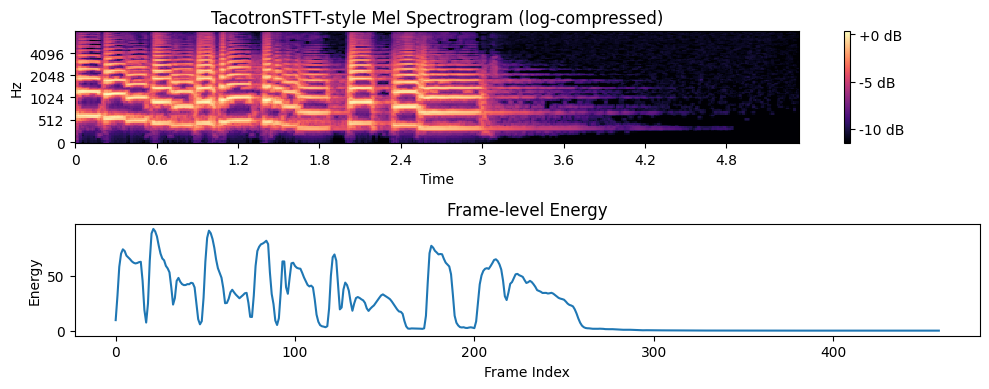

In [ ]:
# 시각화
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spectrogram_normalized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmax=mel_fmax)
plt.title('TacotronSTFT-style Mel Spectrogram (log-compressed)')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
plt.plot(energy)
plt.title('Frame-level Energy')
plt.xlabel('Frame Index')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()